In [452]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
%pylab inline

def error(est, tr):
    return 1.0 * np.abs(est-tr) / tr

def error_dt(row):
    return error(row['adaptives'], row['true_count']), error(row['big_cms'], row['true_count']), \
            error(row['cms'], row['true_count']), row['true_count']


def plot(f='adaptive_res.txt', small_w=256, depth=8, layers=8):    
    adaptives = []
    big_cmss = []
    cmss = []
    true_counts = []
    with open(f, 'r') as f:
    #with open('res_zipf', 'r') as f:
        res = f.readlines()

    for l in res:
        adaptive, big_cms, cms, true_count = l.split(',')
        #keys.append(k1)
        adaptives.append(int(adaptive))
        big_cmss.append(int(big_cms))
        cmss.append(int(cms))
        true_counts.append(int(true_count))

    d = pd.DataFrame(columns=['adaptives',
                             'big_cms',
                             'cms',
                             'true_count'])

    d.adaptives = adaptives
    d.big_cms = big_cmss
    d.cms = cmss
    d.true_count = true_counts
    d.sort_values('true_count', ascending=False, inplace=True)
    d_error = d.apply(error_dt, axis=1)
    d_err = pd.DataFrame()
    d_err['adap'] = list(map(lambda x: x[0], d_error))
    d_err['big_cms'] = list(map(lambda x: x[1], d_error))
    d_err['cms'] = list(map(lambda x: x[2], d_error))

    
    big_w = small_w * layers
    small_epsilon = np.e / small_w
    big_epsilon = np.e / big_w

    s_add_error = small_epsilon * sum(d.true_count)
    b_add_error = big_epsilon * sum(d.true_count)

    d_err['cms_error_bound'] = list(map(lambda x: 1.0 * (s_add_error) / x[3], d_error))
    d_err['bcms_error_bound'] = list(map(lambda x: 1.0 * (b_add_error) / x[3], d_error))

    m_error = np.mean(d_err[:(1<<10)])
    m_error_a = np.mean(d_err)

    d_err[:(1<<10)].plot(title = 'Width {}, depth {}'.format(small_w, 8),\
                        figsize=(15,15),\
                        )
    plt.xlabel('rank')
    plt.ylabel('error rate')
    plt.text(1<<9,d_err[:1<<10].max(axis=0 ).max(), 
             'topk mean error, adaptive {:0.2f}, cms {:0.2f}, big cms {:0.2f} \
             mean error, adaptive {:0.2f}, cms {:0.2f}, big cms {:0.2f}'.
             format(m_error['adap'], m_error['cms'], m_error['big_cms'],\
                   m_error_a['adap'], m_error_a['cms'], m_error_a['big_cms']), ha='center')
    
    plt.savefig('figures/{}_width{}_depth{}_rows{}.png'.format(file,small_w, depth, layers))
    return 0

def plot_topk(file='adaptive_res.txt', small_w=256, depth=8, layers=8, topk=10):    
    adaptives = []
    big_cmss = []
    cmss = []
    true_counts = []
    with open(file, 'r') as f:
    #with open('res_zipf', 'r') as f:
        res = f.readlines()

    for l in res:
        adaptive, big_cms, cms, true_count = l.split(',')
        #keys.append(k1)
        adaptives.append(int(adaptive))
        big_cmss.append(int(big_cms))
        cmss.append(int(cms))
        true_counts.append(int(true_count))

    d = pd.DataFrame(columns=['adaptives',
                             'big_cms',
                             'cms',
                             'true_count'])
    
    d.adaptives = adaptives
    d.big_cms = big_cmss
    d.cms = cmss
    d.true_count = true_counts
    d.sort_values('true_count', ascending=False, inplace=True)
    d_error = d.apply(error_dt, axis=1)
    d_err = pd.DataFrame()
    d_err['adapatives'] = list(map(lambda x: x[0], d_error))
    d_err['big_cms'] = list(map(lambda x: x[1], d_error))
    d_err['cms'] = list(map(lambda x: x[2], d_error))
    big_w = small_w * layers
    small_epsilon = np.e / small_w
    big_epsilon = np.e / big_w

    s_add_error = small_epsilon * sum(d.true_count)
    b_add_error = big_epsilon * sum(d.true_count)

    d_err['cms_error_bound'] = list(map(lambda x: 1.0 * (s_add_error) / x[3], d_error))
    d_err['bcms_error_bound'] = list(map(lambda x: 1.0 * (b_add_error) / x[3], d_error))

    m_error = np.mean(d_err[:topk])
    m_error_a = np.mean(d_err)

    plt.figure()
    d_err_p = pd.DataFrame(columns=['error', 'category'])
    d_err_p.loc[:len(d_err),:] = zip(d_err['big_cms'], ['bcms']*len(d_err))
    d_err_p.loc[:len(d_err),:] = zip(d_err['adaptives'], ['adaptives']*len(d_err))
    #d_err_p = d_err.loc[:topk, ['big_cms', 'adapatives']]
    sns.relplot(y='error', data=d_err_p)
    #d_err_p.plot(
        #title = 'Width {}, depth {}, rows {}, top{}'.format(small_w, depth, layers, topk),\
        #figsize=(15,15),
          #  )
    plt.xlabel('rank')
    plt.ylabel('error rate')
    plt.text(topk/2 ,d_err_p.max(axis=1 ).max(), 
             'top{} mean error, adaptive {:0.2f}, cms {:0.2f}, big cms {:0.2f}, \
             mean error, adaptive {:0.2f}, cms {:0.2f}, big cms {:0.2f}'.
             format(topk, m_error['adapatives'], m_error['cms'], m_error['big_cms'],\
                   m_error_a['adapatives'], m_error_a['cms'], m_error_a['big_cms']), ha='center')
    
    #plt.savefig('figures/{}_width{}_depth{}_rows{}_top{}'.format(file, small_w, depth, layers, topk))
    return 0


def read_res(f):
    adaptives = []
    big_cmss = []
    cmss = []
    true_counts = []
    #64_4_16_1000_4096
    width, depth, row, threshold, memory = list(map(int, f.split('_')))
    small_w = width
    with open('res/'+f, 'r') as f:
    #with open('res_zipf', 'r') as f:
        res = f.readlines()

    for l in res:
        adaptive, big_cms, cms, true_count = l.split(',')
        #keys.append(k1)
        adaptives.append(int(adaptive))
        big_cmss.append(int(big_cms))
        cmss.append(int(cms))
        true_counts.append(int(true_count))

    d = pd.DataFrame(columns=[
                              'adaptives',
                              'big_cms',
                              'cms',
                              'true_count'])

    d.adaptives = adaptives
    d.big_cms = big_cmss
    d.cms = cmss
    d.true_count = true_counts
    #d.sort_values('true_count', ascending=False, inplace=True)
    d_err = pd.DataFrame(columns=['width', 'height', 'row', 'threshold', 'category', 'error' ])
    #d.iloc[:, :-1] = 1.0 * (d.iloc[:, :-1]-d.loc[:, 'true_count']) / d.loc[:, "true_count"] #.apply(error_dt, axis=1)
    tc = d.true_count
    d = d.sub(tc, axis=0)
    d = d.div(tc, axis=0)
    t = pd.DataFrame(list(map(lambda x: [width, depth, row, threshold, 'adaptive', x], d.adaptives)), 
                     columns=['width', 'height', 'row', 'threshold', 'category', 'error' ])
    d_err = d_err.append(t)
    t = pd.DataFrame(list(map(lambda x: [width, depth, row, threshold, 'bcms', x], d.big_cms)), 
                     columns=['width', 'height', 'row', 'threshold', 'category', 'error' ])
    d_err = d_err.append(t)
    #d_err.at[len(d):1*len(d), 'error'] = d['big_cms']
    #d_err['error'] =  list(d['big_cms']).append(list(d['adaptives']))
    
    #d_err['width'] = width
    #print(list(zip([width, depth, row, threshold, 'bcms']*len(d), d['big_cms']))[:10])
    #print(d_err.head())
    
    #for i in range(len(d)):
        #d_err.loc[2*i] = [width, depth, row, threshold, d.loc[i, 'adaptives'], 'adaptive']
        #d_err.loc[2*i +1] = [width, depth, row, threshold, d.loc[i, 'big_cms'], 'big_cms']

    big_w = small_w * row
    small_epsilon = np.e / small_w
    big_epsilon = np.e / big_w

    s_add_error = small_epsilon * sum(d.true_count)
    b_add_error = big_epsilon * sum(d.true_count)

    #d_err['cms_error_bound'] = list(map(lambda x: 1.0 * (s_add_error) / x[3], d_error))
    #d_err['bcms_error_bound'] = list(map(lambda x: 1.0 * (b_add_error) / x[3], d_error))

    m_error = np.mean(d_err[:(1<<10)])
    m_error_a = np.mean(d_err)

    return d_err

Populating the interactive namespace from numpy and matplotlib


/home/ch/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plot', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [435]:
r = pd.DataFrame()
c = 0
for dirpath, dirnames, filenames in os.walk('./res/'):
    print("has {} files".format(len(filenames)))
    for f in filenames:
        if f.endswith('4096'):
            w, d, rows, t, T = f.split('_')
            #plot_topk('res/'+f, small_w=int(w), depth=int(d), layers=int(rows), topk=1000)
            r = r.append(read_res(f))
            print(c, f)
            c+= 1
    break

has 22 files
0 128_8_4_1000_4096
1 256_4_4_1000_4096
2 8_128_4_1000_4096
3 32_2_64_1000_4096
4 2_512_4_1000_4096
5 4_256_4_1000_4096
6 32_32_4_1000_4096
7 2048_2_1_1000_4096
8 1_1024_4_1000_4096
9 16_64_4_1000_4096
10 16_2_128_1000_4096
11 512_2_4_1000_4096
12 64_2_32_1000_4096
13 8_2_256_1000_4096
14 4_2_512_1000_4096
15 64_16_4_1000_4096
16 1_2_2048_1000_4096
17 1024_1_4_1000_4096
18 1024_2_2_1000_4096
19 2_2_1024_1000_4096
20 256_2_8_1000_4096
21 128_2_16_1000_4096


In [436]:
rr.loc[1024]

,width,height,row,threshold,category,error
1024,128,2,16,1000,adaptive,-1.0
1024,128,2,16,1000,bcms,-1.0


## Fix memory space, find the best height

In [437]:
r.head()

,width,height,row,threshold,category,error
0,128,8,4,1000,adaptive,0.001181
1,128,8,4,1000,adaptive,0.000000
2,128,8,4,1000,adaptive,0.000000
3,128,8,4,1000,adaptive,0.000000
4,128,8,4,1000,adaptive,0.005525


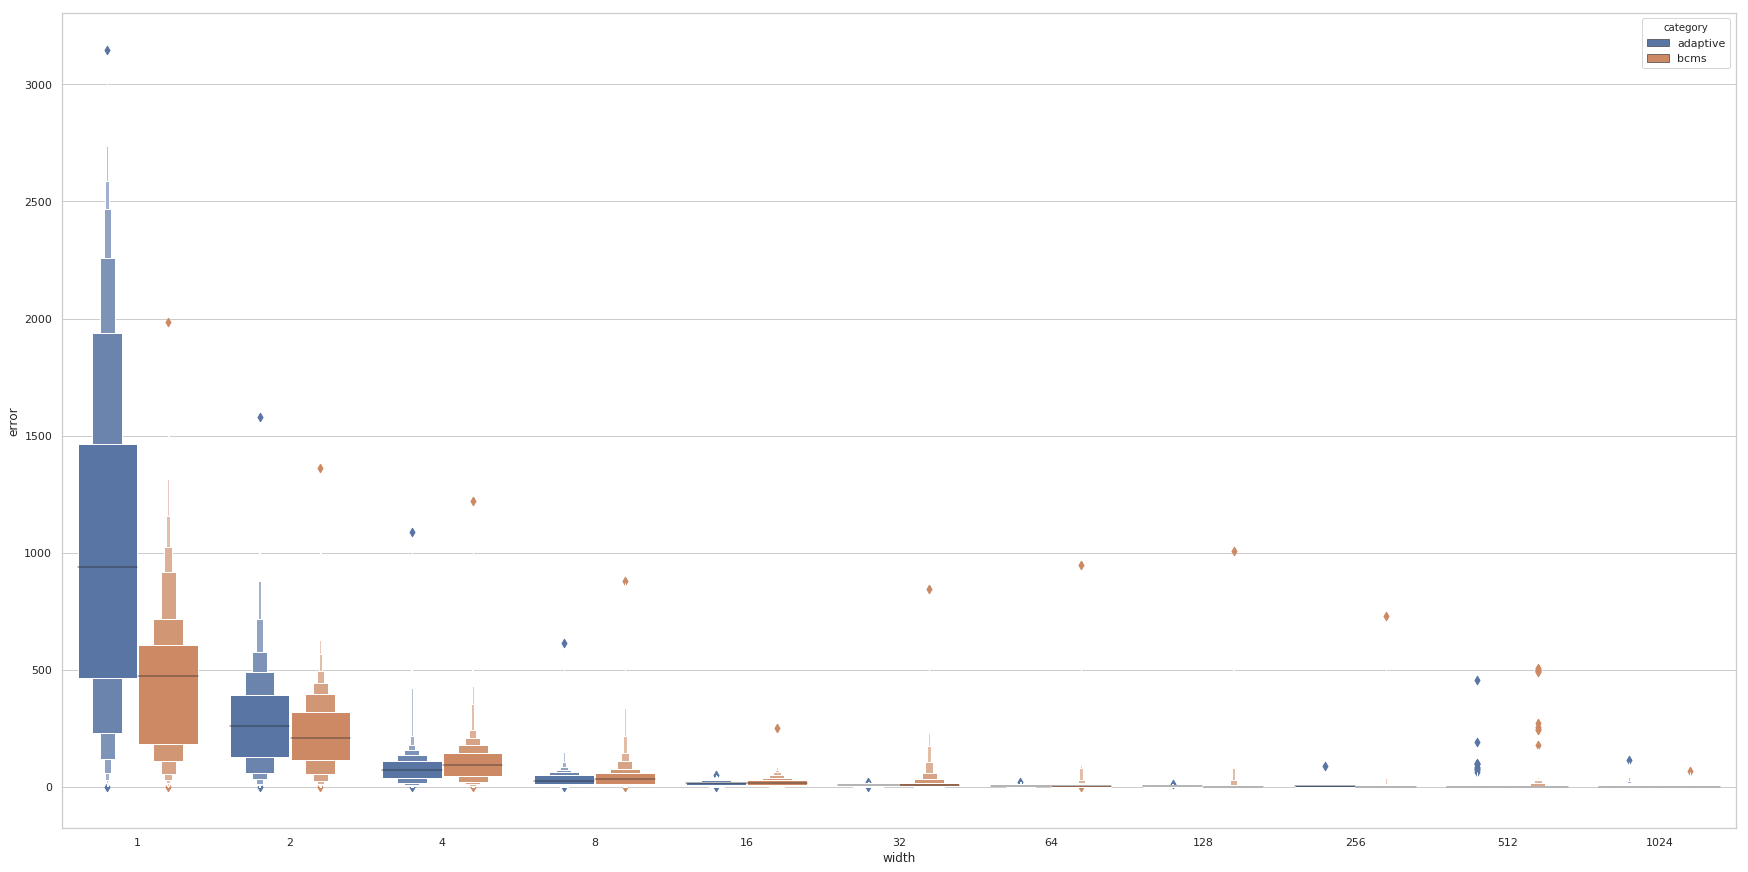

In [438]:
r_height = r[r.row==4]
plt.figure(figsize=[30,15])
sns.boxenplot(x='width', y='error', hue='category', data=r_height)
#plt.ylim([0,100])
#ax = sns.lineplot(x="width", y="error", hue='category', data=r)
#ax = sns.swarmplot(x='width', y='error', hue='category', data=r)
#plt.ylim([0,100])

(0, 50)

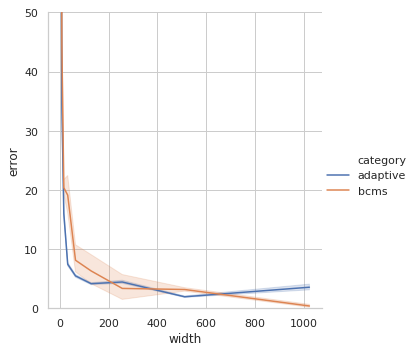

In [447]:
# lineplot: 
sns.relplot(x="width", y="error", hue='category', kind='line', data=r_height)
plt.ylim([0,50])
# when adaptive width=256 or 512, big cms's width = 256*4, 512*4, the two performs similar
# pick height=4096/4/512 = 2 for future experiment

###  pick height=4096/4/512 = 2 for future experiment
## Fix memory, investigate rows. adaptive rows = 4096/2/width

In [448]:
r_rows = r[r.height==2]

(0, 10)

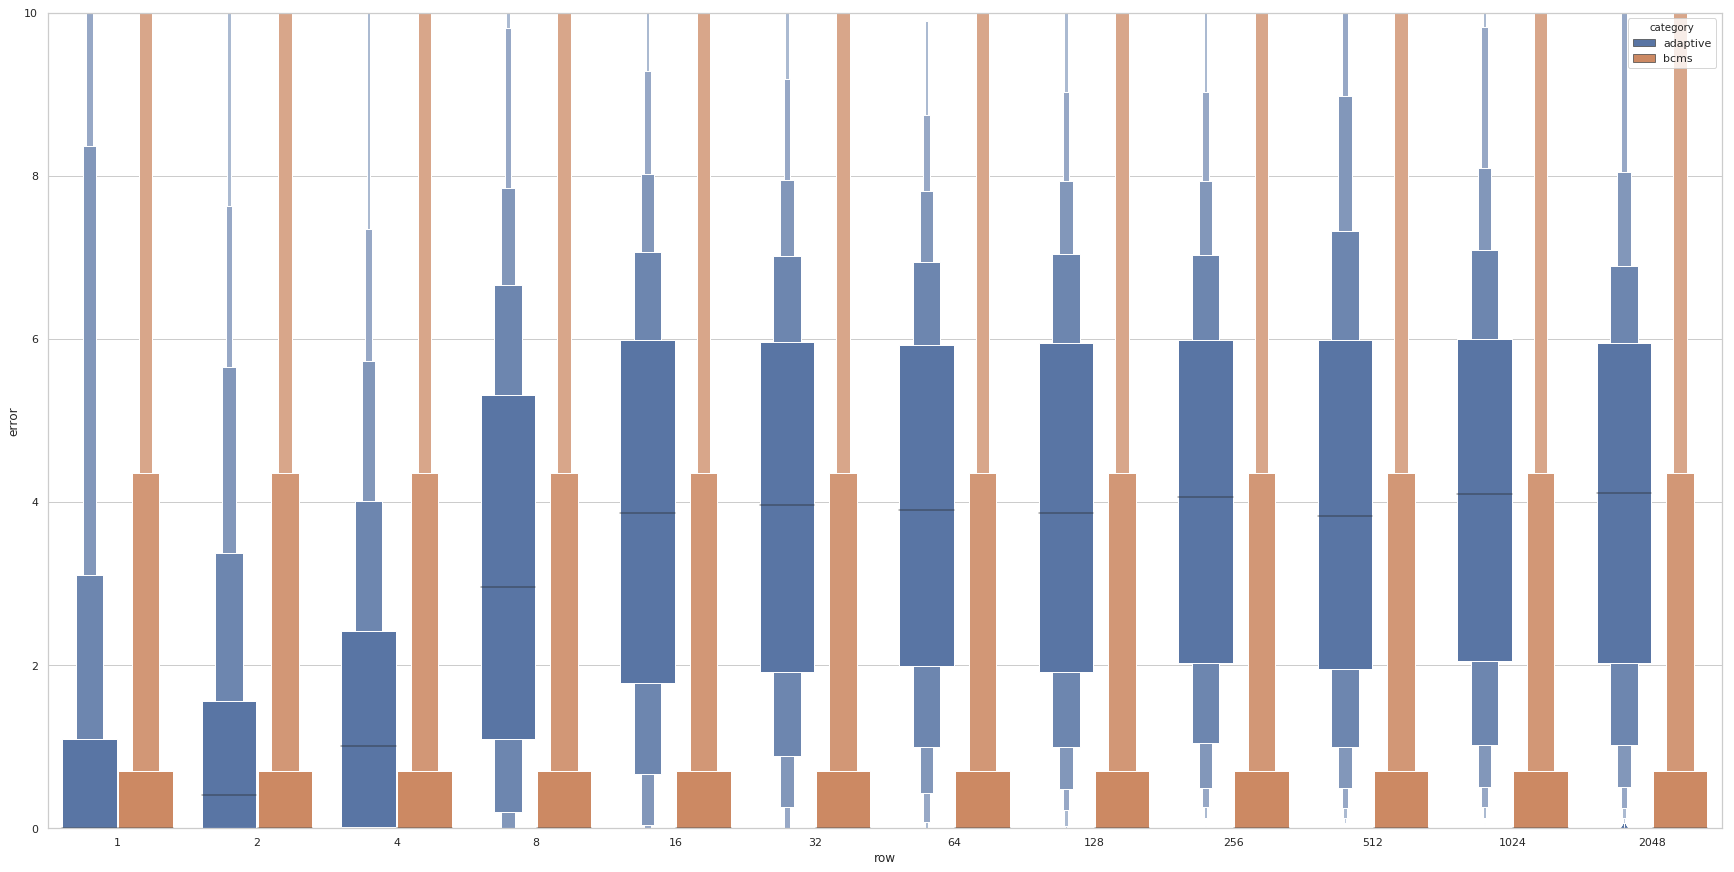

In [454]:
plt.figure(figsize=[30,15])
sns.boxenplot(x='row', y='error', hue='category', data=r_rows)
plt.ylim([0,10])

(1, 20)

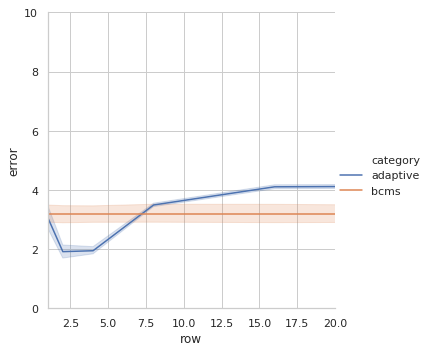

In [463]:
sns.relplot(x="row", y="error", hue='category', kind='line', data=r_rows)
plt.ylim([0,10])
plt.xlim([1,20])

### Note in the above plot, big cms is the same across x axis because row == 1, width == 4096/2

### experiment 'row' linearly over [1, 10]

In [467]:
r_rows_zoom = pd.DataFrame()
c = 0
for dirpath, dirnames, filenames in os.walk('./res/'):
    print("has {} files".format(len(filenames)))
    for f in filenames:

        w, d, rows, t, T = f.split('_')
        if (int(d)==2) and (int(rows)<=10):
            #plot_topk('res/'+f, small_w=int(w), depth=int(d), layers=int(rows), topk=1000)
            r_rows_zoom = r_rows_zoom.append(read_res(f))
            print(c, f)
            c+= 1
        else:
            continue
    break

has 28 files
0 409_2_5_1000_4090
1 682_2_3_1000_4092
2 341_2_6_1000_4092
3 2048_2_1_1000_4096
4 204_2_10_1000_4080
5 292_2_7_1000_4088
6 512_2_4_1000_4096
7 1024_2_2_1000_4096
8 227_2_9_1000_4086
9 256_2_8_1000_4096


(1, 10)

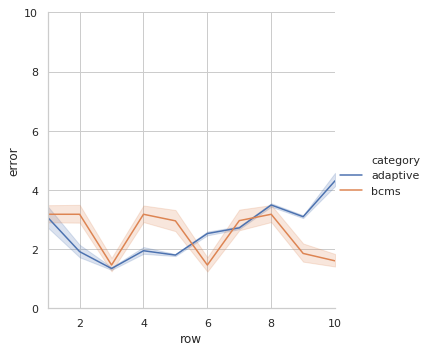

In [469]:
sns.relplot(x="row", y="error", hue='category', kind='line', data=r_rows_zoom)
plt.ylim([0,10])
plt.xlim([1,10])

## From the plot above, row=4 is optimized

### Note in the above plot, big cms changes because row == 1, width = total_memory/2. And total_memory flucatuate because of floating numbers

## experiment over threshold. Fix CMS configure: width=512, height=2, row=4
### total memory = 4096

In [483]:
r_threshold = pd.DataFrame()
c = 0
for dirpath, dirnames, filenames in os.walk('./res/'):
    print("has {} files".format(len(filenames)))
    for f in filenames:
        w, d, rows, t, T = f.split('_')
        if (int(w)==512) and (int(d)==2) and (int(rows)==4):
            #plot_topk('res/'+f, small_w=int(w), depth=int(d), layers=int(rows), topk=1000)
            r_threshold = r_threshold.append(read_res(f))
            print(c, f)
            c+= 1
        else:
            continue
    break

has 46 files
0 512_2_4_4_4096
1 512_2_4_64_4096
2 512_2_4_1_4096
3 512_2_4_8192_4096
4 512_2_4_128_4096
5 512_2_4_2048_4096
6 512_2_4_131072_4096
7 512_2_4_1000_4096
8 512_2_4_1024_4096
9 512_2_4_65536_4096
10 512_2_4_4096_4096
11 512_2_4_32768_4096
12 512_2_4_8_4096
13 512_2_4_2_4096
14 512_2_4_16_4096
15 512_2_4_256_4096
16 512_2_4_16384_4096
17 512_2_4_32_4096
18 512_2_4_512_4096


(0, 10)

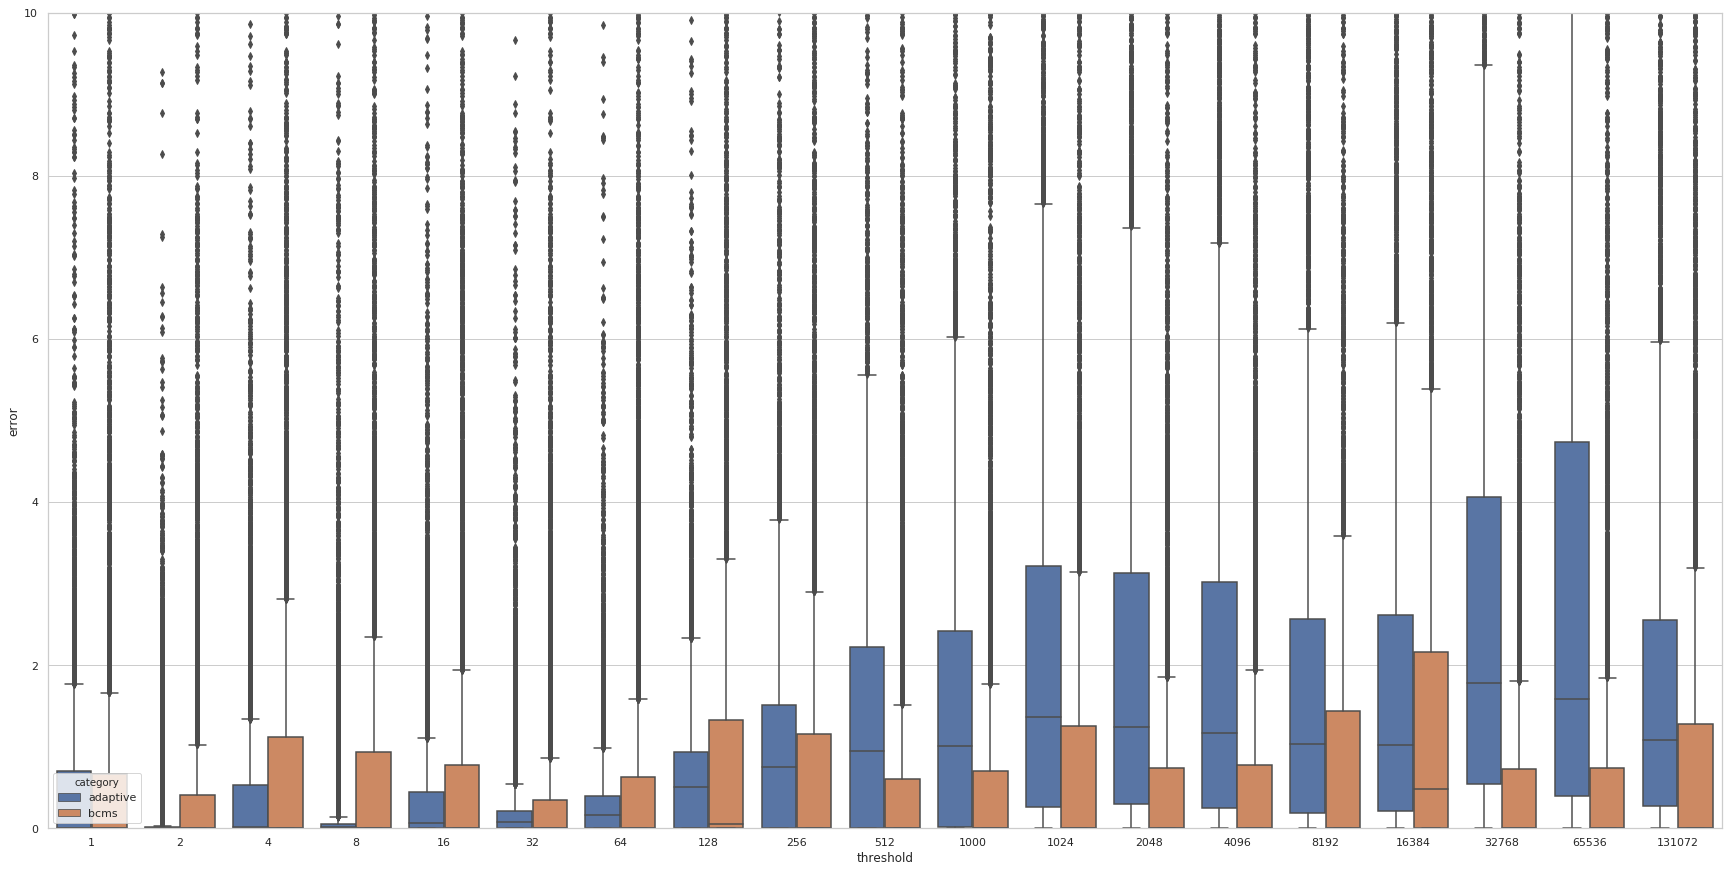

In [509]:
plt.figure(figsize=[30,15])
sns.boxplot(x='threshold', y='error', hue='category', data=r_threshold)
plt.ylim([0,10])

(1, 20000)

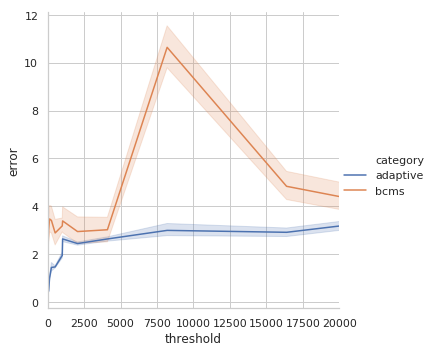

In [484]:
sns.relplot(x="threshold", y="error", hue='category', kind='line', data=r_threshold)
#plt.ylim([0,10])
plt.xlim([1,20000])